# The representation of women in the cinematic industry over the years

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

from scipy import stats
from itertools import islice
from wordcloud import WordCloud
from sklearn.linear_model import LinearRegression

In [2]:
DATA_PATH = "MovieSummaries"
MOVIE_PATH = DATA_PATH + "/movie.metadata.tsv"
CHARACTER_PATH = DATA_PATH + "/character.metadata.tsv"
CHARACTER_TYPE_PATH = DATA_PATH + "/tvtropes.clusters.txt"

In [3]:
def convert_date(date_string):
    """
    Convert a date string to a pandas datetime object.

    Parameters:
    - date_string (str): The input date string to be converted.

    Returns:
    - pd.Timestamp: A pandas datetime object representing the converted date.

    Raises:
    - ValueError: If the input date string cannot be converted using any of the specified formats.
    """
    try:
        return pd.to_datetime(date_string, format='%Y-%m-%d')
    except ValueError:
        try:
            return pd.to_datetime(date_string, format='%Y-%m')
        except ValueError:
            try:
                return pd.to_datetime(date_string, format='%Y')
            except ValueError:
                return pd.to_datetime(date_string, format='%Y-%m-%d %H:%M:%S.%f')  

---

### GENERAL ANALYSIS

---

### DATA PREPROCESSING

For this analysis, we will use the files movies.metadata and characters.metadata. 

In [4]:
# Load the datasets
headers_movies = ['WikiMovieID', 
                  'FreebaseMovieID', 
                  'MovieName', 
                  'ReleaseDate', 
                  'BORevenue', 
                  'Runtime',
                  'Languages', 
                  'Countries', 
                  'MovieGenre']

headers_characters = ['WikiMovieID', 
                      'FreebaseMovieID', 
                      'ReleaseDate', 
                      'CharacterName', 
                      'DoB', 
                      'Gender', 
                      'Height', 
                      'Ethnicity', 
                      'ActorName', 
                      'Age', 
                      'FreebaseActorMapID', 
                      'FreebaseCharacterID', 
                      'FreebaseActorID']

movies = pd.read_csv(MOVIE_PATH, sep='\t', names=headers_movies)
characters = pd.read_csv(CHARACTER_PATH, sep='\t', names=headers_characters)

In [5]:
# Merge the 2 datasets according to the common columns, and drop the columns that we don't need
cmu = movies.merge(characters, how='left', on=['WikiMovieID', 'FreebaseMovieID', 'ReleaseDate'])
cmu = cmu.drop('DoB', axis=1)
cmu = cmu.drop('ActorName', axis=1)
cmu.sample(2)

,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Runtime,Languages,Countries,MovieGenre,CharacterName,Gender,Height,Ethnicity,Age,FreebaseActorMapID,FreebaseCharacterID,FreebaseActorID
370568,10292462,/m/02q7m1k,The Desert Song,1929-04-08,NaN,123.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/09swn"": ""Operetta"", ""/m/0520lz"": ""Roadsho...",NaN,F,NaN,NaN,NaN,/m/05bhlkq,NaN,/m/05bhlkt
368082,9706751,/m/02ppqzh,Suzy,1936,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02l7c8"": ""Romance Film"", ""/m/02kdv5l"": ""A...",NaN,M,1.78,NaN,30.0,/m/02vcr5l,NaN,/m/012dtf


In [6]:
# Keep only the rows for which we have the gender of the actor
cmu = cmu.loc[cmu['Gender'].isin(['F', 'M'])].copy(deep=True)

# The movie 'Hunting Season' has an incorrect data: 1010 instead of 2010
cmu['ReleaseDate'] = cmu['ReleaseDate'].replace('1010-12-02', '2010-12-02')
# Convert the date in the column 'ReleaseDate' into datetime
ReleaseDate_datatime = cmu['ReleaseDate'].apply(convert_date)
# Add a column with the year of release only
cmu['ReleaseYear'] = ReleaseDate_datatime.dt.year.fillna(0).astype(int)
cmu['ReleaseYear'] = cmu['ReleaseYear'].astype('int64')
cmu['ReleaseYear'].replace(0, np.nan, inplace=True)

# Convert the str-like dictionaries to dictionaries
cmu['Countries'] = cmu['Countries'].apply(ast.literal_eval)
cmu['MovieGenre'] = cmu['MovieGenre'].apply(ast.literal_eval)
cmu['Languages'] = cmu['Languages'].apply(ast.literal_eval)

# Remove outliers for age and replace null or negative values by NaN
cmu['Age'] = cmu['Age'].apply(lambda x: np.nan if x <= 0 else x)

# Keep only movies between 1912 and 2012 to have at least 200 movies per year
cmu = cmu.loc[(cmu['ReleaseYear'] >= 1912) & (cmu['ReleaseYear'] <= 2012)]

# Drop outliers for height
Q1 = cmu['Height'].quantile(0.25)
Q3 = cmu['Height'].quantile(0.75)
IQR = Q3 - Q1
cmu = cmu[(cmu['Height'] > Q1 - 1.5 * IQR) & (cmu['Height'] < Q3 + 1.5 * IQR)]

# Drop outliers for Runtime
lower, upper = 40, 180
cmu = cmu[(cmu['Runtime'] >= lower) & (cmu['Runtime'] <= upper)]

In [7]:
cmu.sample(4)

,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Runtime,Languages,Countries,MovieGenre,CharacterName,Gender,Height,Ethnicity,Age,FreebaseActorMapID,FreebaseCharacterID,FreebaseActorID,ReleaseYear
447495,21034279,/m/05b0yy0,Scandal at Scourie,1953-05-17,NaN,90.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},{'/m/07s9rl0': 'Drama'},NaN,F,1.670,/m/07bch9,48.0,/m/05cn8hf,NaN,/m/0h1s0,1953.0
291582,2354621,/m/07626w,Fur,2006-11-10,NaN,122.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/068d7h': 'Romantic drama', '/m/02l7c8': '...",Diane Arbus,F,1.791,/m/03bkbh,39.0,/m/02tb34n,/m/04dsqjn,/m/05dbf,2006.0
296993,11536207,/m/02rh46b,Sargam,1979-01-08,NaN,146.0,{'/m/03k50': 'Hindi Language'},{'/m/03rk0': 'India'},"{'/m/03q4nz': 'World cinema', '/m/01chg': 'Bol...",Raju,M,1.700,/m/02sch9,26.0,/m/0dgb1hr,/m/0dgb1hm,/m/03f02ct,1979.0
150674,893808,/m/03mh94,Robots,2005,260718330.0,90.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/06n90': 'Science Fiction', '/m/03k9fj': '...",Broken Arm Bot,M,1.900,NaN,56.0,/m/0cs9p6y,/m/0ghg1qh,/m/0gc0d,2005.0


---

## AGE: IS THERE A DIFFERENCE ?

---

We often hear clichés about the evolution of beauty with age: women are described as blossoming in their youth, while men become more handsome with age. An intriguing question arises: does this perceived divergence in the aesthetics of aging manifest itself in the film industry, and if so, is this disparity statistically significant? 

Let's explore the data !

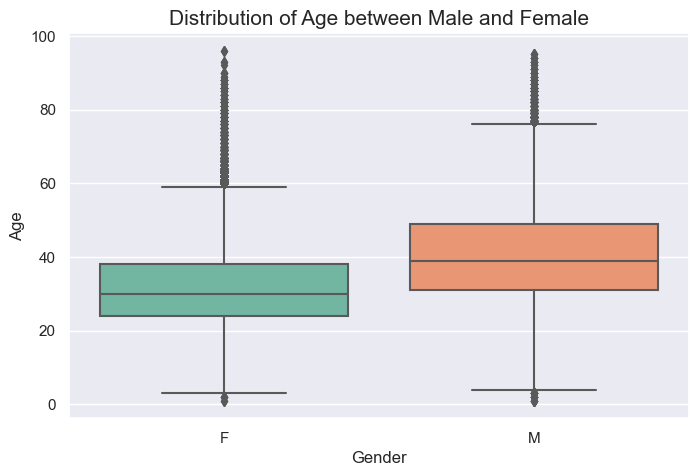

In [8]:
# Set the plot style and color palette
sns.set(style="darkgrid", palette="Set2")

plt.figure(figsize=(8, 5))

sns.boxplot(x='Gender', y='Age', data=cmu)
plt.title('Distribution of Age between Male and Female', fontsize=15)

plt.xlabel('Gender', fontsize=12)
plt.ylabel('Age', fontsize=12)

plt.show()

In [9]:
women_cmu = cmu.loc[cmu['Gender']=='F'].copy(deep=True)
men_cmu = cmu.loc[cmu['Gender']=='M'].copy(deep=True)

In [10]:
# T-test to determine if the difference in age between men and women is statistically significant 
stats.ttest_ind(women_cmu['Age'], men_cmu['Age'], nan_policy='omit')

TtestResult(statistic=-104.28126043126201, pvalue=0.0, df=124768.0)

We used a two-sided t-test for the null hypothesis that the age of actors and actresses have identical average (expected) values. The p-value is much smaller than 0.05, therefore we can reject the null hypothesis, meaning that there is a statistically significant difference in the average ages between the two groups. As the t-statistic is strongly negative (-104), it supports our conclusion that women are significantly younger than men.

### Has this tendency evolved with years ?

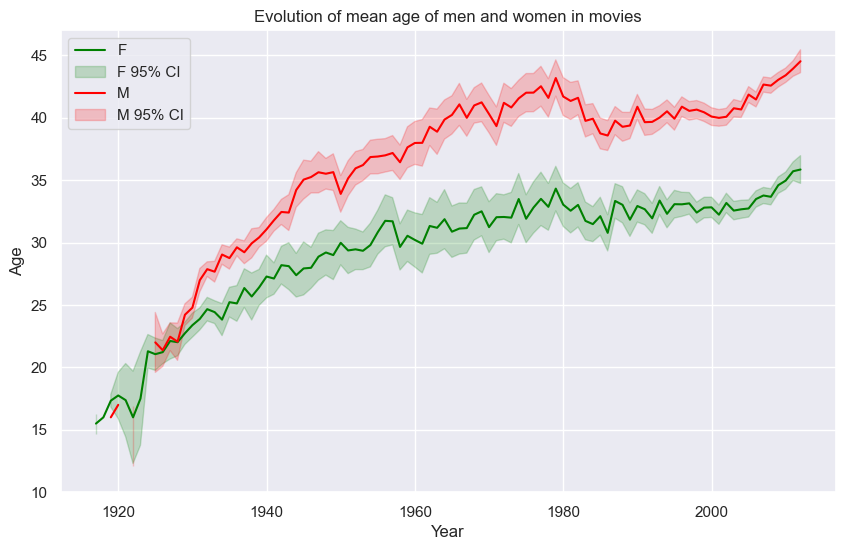

In [11]:
#Calculate the mean age of actors and actress in movies across year
women_mean_age_per_year = women_cmu.groupby('ReleaseYear').agg({'Age': 'mean'})
men_mean_age_per_year = men_cmu.groupby('ReleaseYear').agg({'Age': 'mean'})

#Calculate the 95% CIs
women_std_age_per_year = women_cmu.groupby('ReleaseYear').agg({'Age': 'std'})
men_std_age_per_year = men_cmu.groupby('ReleaseYear').agg({'Age': 'std'})

z=1.96
upper_bound_women = women_mean_age_per_year['Age'] + z*women_std_age_per_year['Age']/np.sqrt(women_cmu.groupby('ReleaseYear').agg({'CharacterName' : 'count'})['CharacterName'])
lower_bound_women = women_mean_age_per_year['Age'] - z*women_std_age_per_year['Age']/np.sqrt(women_cmu.groupby('ReleaseYear').agg({'CharacterName' : 'count'})['CharacterName'])

upper_bound_men = men_mean_age_per_year['Age'] + z*men_std_age_per_year['Age']/np.sqrt(men_cmu.groupby('ReleaseYear').agg({'CharacterName' : 'count'})['CharacterName'])
lower_bound_men = men_mean_age_per_year['Age'] - z*men_std_age_per_year['Age']/np.sqrt(men_cmu.groupby('ReleaseYear').agg({'CharacterName' : 'count'})['CharacterName'])


#Plot

fig, ax = plt.subplots(figsize=(10, 6))
#plt.figure(figsize=(10, 6))

ax.plot(women_mean_age_per_year, label='F', color='green')
ax.fill_between(women_mean_age_per_year.index, lower_bound_women, upper_bound_women, alpha =0.2, color='green', label = 'F 95% CI')

ax.plot(men_mean_age_per_year, label='M', color='red')
ax.fill_between(men_mean_age_per_year.index, lower_bound_men, upper_bound_men, alpha =0.2, color='red', label = 'M 95% CI')

ax.set_ylim(10,47)
ax.set_xlabel('Year')
ax.set_ylabel('Age')
ax.set_title('Evolution of mean age of men and women in movies')
ax.legend()
plt.show()

---

## PROPORTION OF FEMALE CHARACTERS

---

We will explore the proportion of female characters in movies.

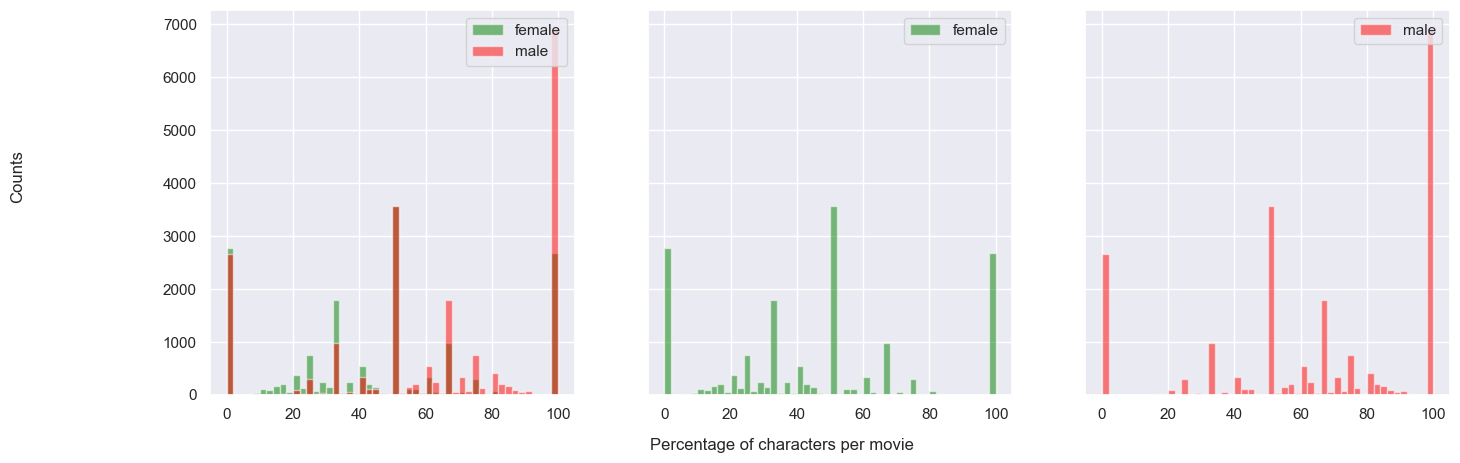

In [12]:
df_gender_proportion_by_movie=pd.DataFrame()
#men_by_movie=pd.DataFrame()

df_gender_proportion_by_movie['MaleCharacters'] = men_cmu.groupby('WikiMovieID')['CharacterName'].nunique()
df_gender_proportion_by_movie['FemaleCharacters'] = women_cmu.groupby('WikiMovieID')['CharacterName'].nunique()

df_gender_proportion_by_movie['TotalNumberofCharacters'] = cmu.groupby('WikiMovieID')['CharacterName'].nunique()

df_gender_proportion_by_movie = df_gender_proportion_by_movie.merge(cmu[['ReleaseYear', 'WikiMovieID']], how='left', left_index=True, right_on='WikiMovieID' )

df_gender_proportion_by_movie['PercentageofFemale'] = df_gender_proportion_by_movie['FemaleCharacters'] / df_gender_proportion_by_movie['TotalNumberofCharacters'] * 100
df_gender_proportion_by_movie['PercentageofMale'] = df_gender_proportion_by_movie['MaleCharacters'] / df_gender_proportion_by_movie['TotalNumberofCharacters'] * 100

df_gender_proportion_by_movie =df_gender_proportion_by_movie.drop_duplicates(subset=['WikiMovieID'])

#Plot
fig, ax = plt.subplots(1, 3, figsize=(16,5), sharey=True)

ax[0].hist(df_gender_proportion_by_movie['PercentageofFemale'], bins=50, label='female', alpha=0.5, color='green')
ax[0].hist(df_gender_proportion_by_movie['PercentageofMale'], bins=50, label='male', alpha=0.5, color='red')
ax[0].legend(loc='upper right') 

ax[1].hist(df_gender_proportion_by_movie['PercentageofFemale'], bins=50, label='female', alpha=0.5, color='green')
ax[1].legend(loc='upper right') 


ax[2].hist(df_gender_proportion_by_movie['PercentageofMale'], bins=50, label='male', alpha=0.5, color='red')
ax[2].legend(loc='upper right') 

fig.text(0.4,0, "Percentage of characters per movie")
fig.text(0,0.5, "Counts", rotation = 90)

plt.show()

---

## GENRE OF MOVIE: IS THERE A DIFFERENCE ?

---

An often-repeated stereotype regarding women suggests that they are not inclined towards action, sports, or intellectual pursuits, but rather, their primary role is portrayed as being centered around romantic relationships. We aim to investigate whether this stereotype is reflected in the portrayal of women in movies from our dataset.

We will do our analysis only based on the 16 major genres of movie in the dataset. First, we need to determine what these 16 genres are.

In [13]:
# Filter the cmu dataset to get only 1 row per movie. Otherwise, the genres are counted too many times
cmu_without_duplicates = cmu.drop_duplicates(subset=['WikiMovieID'], keep='first')

In [14]:
all_unique_genres = set()

# Get all the movie genres
cmu_without_duplicates['MovieGenre'].apply(lambda x: all_unique_genres.update(x.values()) if isinstance(x, dict) else None)

# Initialize dictionary with keys and values set to 0
genres_count = {genre: 0 for genre in all_unique_genres}

# Count the occurence of each genre
for row in cmu_without_duplicates['MovieGenre']:
    for key, value in row.items():
        genres_count[value]+=1
        
# Sort the dictionary by values in descending order
genres_count = dict(sorted(genres_count.items(), key=lambda item: item[1], reverse=True))

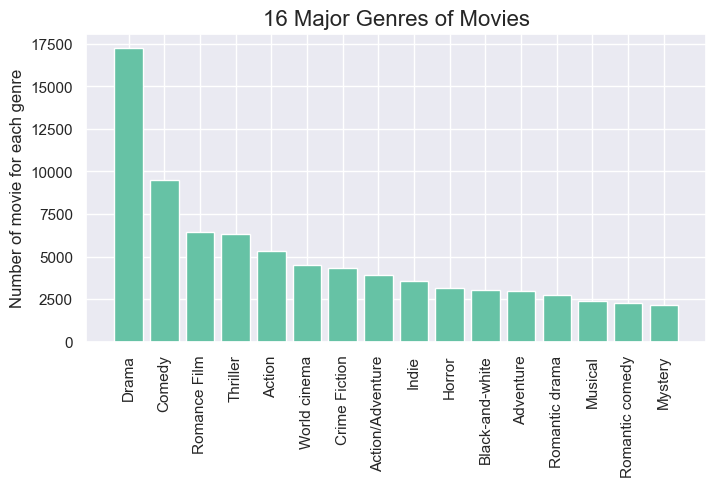

In [15]:
plt.figure(figsize=(8, 4))

# Keep the first 16 major genres
major_16_genres = dict(islice(genres_count.items(), 16))

x = np.arange(len(major_16_genres))

plt.bar(x, major_16_genres.values())
plt.xticks(x, major_16_genres.keys(), rotation='vertical')
plt.title('16 Major Genres of Movies', fontsize=16)
plt.ylabel('Number of movie for each genre')
plt.show()

For the analysis we consider that:
- If a movie has several genres, we will keep the one that appears in the 16 major genres, and if several are in the 16 major genres, we keep the first one.
- If none is in the 16 major genre, or if the genre is not given, then we drop the row

In [16]:
# List of rows to drop 
rows_to_drop = []

cmu_genre = cmu.copy()

for index, row in cmu_genre.iterrows():
    movie_genre = row['MovieGenre']
    
    # If there is one genre only, drop the row if not in the 16 major genre
    if len(movie_genre) == 1 and list(movie_genre.values())[0] not in major_16_genres:
        rows_to_drop.append(index)
        
    # If there is no genre, drop the corresponding row
    elif not bool(movie_genre):
        rows_to_drop.append(index)
            
    # If there are multiple genres        
    else:
        count = 0  # To keep the first value only
        for key, value in movie_genre.items():
            if value in major_16_genres:
                if count == 0:
                    value_to_keep = value
                    key_to_keep = key
                    count = 1
                    break

        if count == 0:  # If none of the genres is in the major_16_genres, drop the row
            rows_to_drop.append(index)

        if count == 1:
            cmu_genre.at[index, 'MovieGenre'] = {key_to_keep: value_to_keep}

# Create a new DataFrame with only the rows to keep
cmu_genre = cmu_genre.drop(rows_to_drop)
movie_counts = cmu_genre['WikiMovieID'].nunique()
print(f'We are left with {movie_counts} movies')

We are left with 31920 movies


To facilitate analysis, we replace the dictionary for the 'MovieGenre' column with a str:

In [17]:
cmu_genre['MovieGenre'] = cmu_genre['MovieGenre'].apply(lambda x: list(x.values())[0])

In [18]:
# Split the dataset in 2 according to actor gender
women_with_genre = cmu_genre.loc[cmu_genre['Gender']=='F'].copy(deep=True)
men_with_genre = cmu_genre.loc[cmu_genre['Gender']=='M'].copy(deep=True)

In [19]:
# Group by 'MovieGenre' and count the number of occurence
women_genre_counts = women_with_genre.groupby('MovieGenre').size().reset_index(name='Women_Count')
men_genre_counts = men_with_genre.groupby('MovieGenre').size().reset_index(name='Men_Count')

# New dataframe with the counts
genre_counts = women_genre_counts.merge(men_genre_counts, how='left', on='MovieGenre')

# Compute the percentage of Women and Men per movie genre
genre_counts['Percent_Women']=(genre_counts['Women_Count']/(genre_counts['Women_Count']+genre_counts['Men_Count']))*100
genre_counts['Percent_Men']=(genre_counts['Men_Count']/(genre_counts['Women_Count']+genre_counts['Men_Count']))*100

In [20]:
genre_counts.sample(2)

,MovieGenre,Women_Count,Men_Count,Percent_Women,Percent_Men
0,Action,928,2468,27.326266,72.673734
3,Black-and-white,343,610,35.991605,64.008395


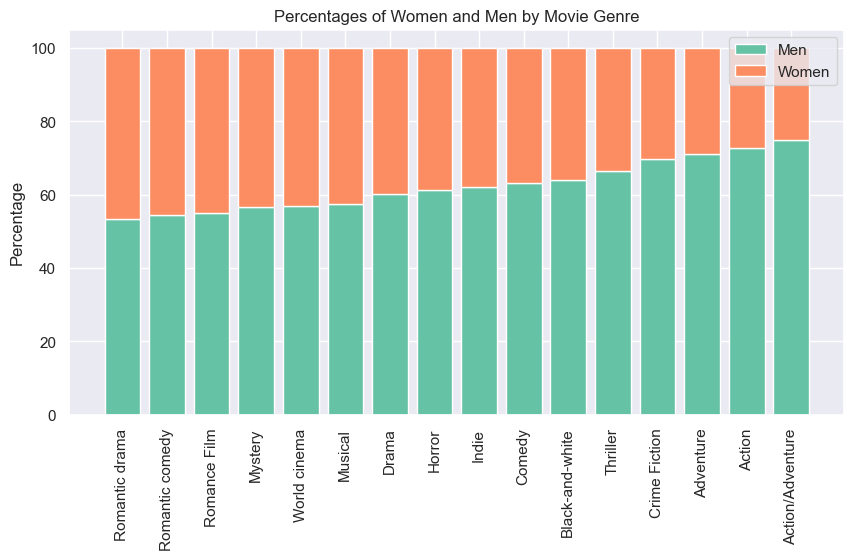

In [21]:
# Plot the percentage of Women and Men per movie genre

# Sort the DataFrame for better visualization
genre_counts = genre_counts.sort_values(by='Percent_Men', ascending=True)

fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(genre_counts['MovieGenre'], genre_counts['Percent_Men'], label='Men')
ax.bar(genre_counts['MovieGenre'], genre_counts['Percent_Women'], bottom=genre_counts['Percent_Men'], label='Women')

plt.xticks(rotation='vertical')
ax.set_ylabel('Percentage')
ax.set_title('Percentages of Women and Men by Movie Genre')
ax.legend()

plt.show()

Is there a difference in actors' ages between genres? 

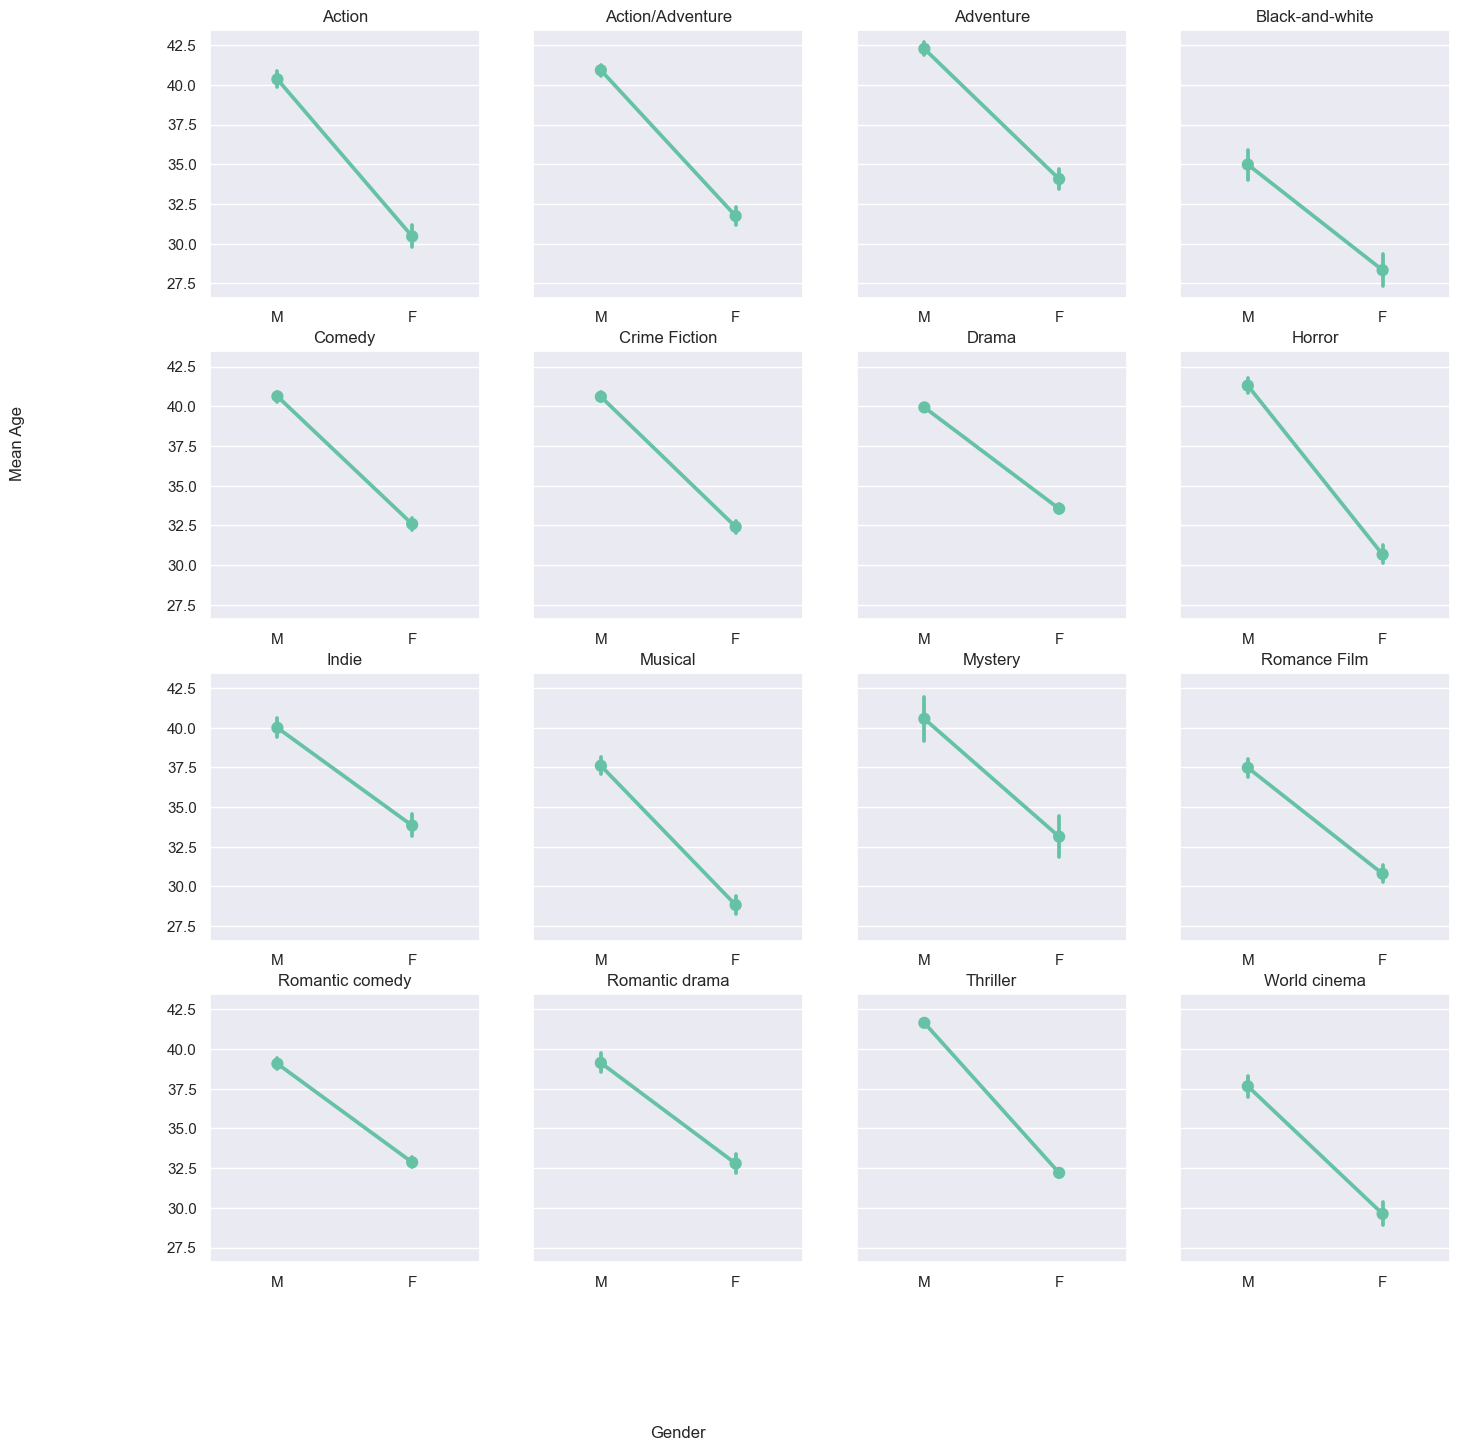

In [22]:
cmu_by_genre = cmu_genre.groupby('MovieGenre')

fig, axes = plt.subplots(4,4,figsize= (16,16), sharey=True)

for genre, ax in zip(cmu_by_genre.groups.keys(), axes.flat):
    sns.set(style="darkgrid", palette="Set2")
    
    plot = sns.pointplot(x='Gender', y='Age', data=cmu_by_genre.get_group(genre), ax=ax, order=['M', 'F'], errorbar=('ci',95))
    plot.set_title(genre)
    plot.set(ylabel=None)
    plot.set(xlabel=None)

fig.text(0.4,0, "Gender")
fig.text(0,0.6, "Mean Age", rotation = 90)

plt.show()

---

## Are more feminine dominated movies more successful ? or more appreciated ?

---

We want to analyse whether the success of a movie is correlated with the proportion of women in a movie. To to this we will take the Boxoffice Revenue as a measure of success, as well as the IMDb ratings given around the world to each movie.

### Looking at the ratings

In [23]:
# IMDb data set merged with the CMU movies
ratings = pd.read_csv('Ratings_PreProcessed.tsv', sep='\t',)

<Axes: xlabel='PercentageofFemale', ylabel='AverageRating'>

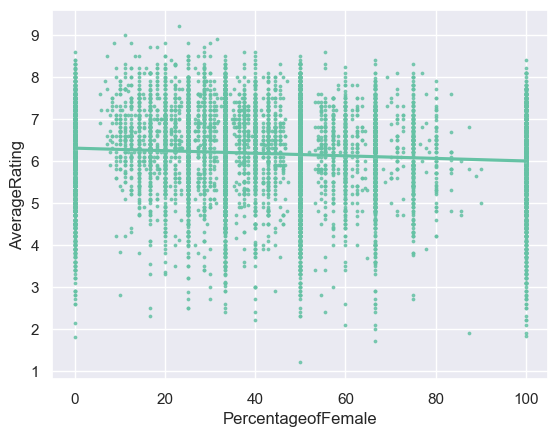

In [42]:
# We are interested in the movies where we have the information on gender distribution so we do a right join
ratings_gender= pd.merge(ratings, df_gender_proportion_by_movie, on = 'WikiMovieID', how= 'right')

# Order according to Percentage of Female
ratings_gender.sort_values( by='PercentageofFemale', inplace = True)

sns.regplot(x = ratings_gender['PercentageofFemale'], y= ratings_gender['AverageRating'], ci = 95, scatter_kws={'s':3})

We do a linear regression to see the correlation between the percentage of women in movies and the rating given on IMDb. This shows us that there is a slight negative correlation, meaning that movies with a higher percentage of women tend to have a slightly worse rating. We need to check this with other statistical metrics. 

### Looking at the Box office revenue

---

## What are the types of characters women interpret ? 

---

Let's uncover whether the common stereotypes about women align with the characters we observe on the screen.


For this analysis, we will use the tvtropes.clusters file

In [ ]:
with open(CHARACTER_TYPE_PATH, 'r') as file:
    lines = file.readlines()
    new_lines = []
    
    for line in lines:
        char_type = line.split()[0]
        char_type_dict = {'CharType': char_type}

        space_index = line.find('	')
        char_info = ast.literal_eval(line[space_index+1:])
        
        new_line = {**char_type_dict, **char_info}
        
        new_lines.append(new_line)
    

# Evaluate each line and extract the column name and corresponding dictionary

headers_names = ['CharType',
                 'CharName',
                 'MovieName',
                 'FreebaseActorMapID',
                 'ActorName']

chartypes = pd.DataFrame(new_lines)
chartypes.columns = headers_names
chartypes.head()

,CharType,CharName,MovieName,FreebaseActorMapID,ActorName
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader


In [ ]:
chartype_cmu = cmu.merge(chartypes, how='right', on=['FreebaseActorMapID', 'MovieName'])
chartype_women = chartype_cmu.loc[chartype_cmu['Gender']=='F'].copy(deep=True)
chartype_men = chartype_cmu.loc[chartype_cmu['Gender']=='M'].copy(deep=True)

In [ ]:
women_counts = chartype_women['CharType'].value_counts().head(5)
men_counts = chartype_men['CharType'].value_counts().head(5)

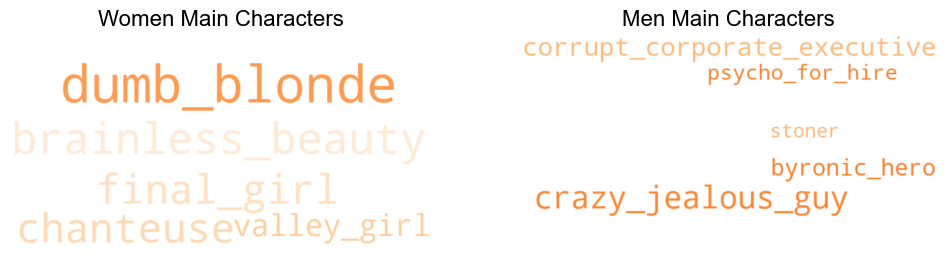

In [ ]:
# Create WordClouds for women and men
women_wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="Oranges").generate_from_frequencies(women_counts)
men_wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="Oranges").generate_from_frequencies(men_counts)

# Plotting the WordClouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(women_wordcloud, interpolation="bilinear")
plt.title("Women Main Characters", color="black", fontsize=16)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(men_wordcloud, interpolation="bilinear")
plt.title("Men Main Characters", color="black", fontsize=16)
plt.axis("off")

plt.show()